different models testing

## Import Libraries

In [56]:
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import glob, os
# os.chdir("/Users/choyademacbook/Desktop/2020Spring/IMT575/finalProject/")

## Prepare Data
- import data

In [57]:
trainOrigin = pd.read_csv("./yelp_feature_train.csv", encoding='utf-8')
testOrigin = pd.read_csv("./yelp_feature_test.csv", encoding='utf-8')
valOrigin = pd.read_csv("./yelp_feature_val.csv", encoding='utf-8')
trainOrigin.shape, testOrigin.shape, valOrigin.shape

((428724, 18), (129141, 18), (102135, 18))

In [58]:
trainOrigin.dtypes

business_id                object 
user_id                    object 
review_stars               float64
review_like                int64  
text                       object 
text_len                   int64  
restaurant_avg_stars       float64
restaurant_review_count    int64  
city_review_count          float64
centrality                 float64
user_avg_stars             float64
user_review_count          int64  
user_fans                  int64  
user_period                int64  
user_compliments           int64  
user_votes                 int64  
popularity                 float64
pop_label                  float64
dtype: object

In [59]:
#trainOrigin.head(3)

<font color=red>- encode labels to one-hot</font>

In [60]:
'''
# encode labels to one-hot
values_dict = {1:[0,0,0,0],
               2:[1,0,0,0],
               3:[1,1,0,0],
               4:[1,1,1,0],
               5:[1,1,1,1]}

resultDF['temp'] = resultDF['real_label'].map(values_dict)
resultDF[['encode_1','encode_2','encode_3','encode_4']] = resultDF['pop_label'].apply(pd.Series)
'''

"\n# encode labels to one-hot\nvalues_dict = {1:[0,0,0,0],\n               2:[1,0,0,0],\n               3:[1,1,0,0],\n               4:[1,1,1,0],\n               5:[1,1,1,1]}\n\nresultDF['temp'] = resultDF['real_label'].map(values_dict)\nresultDF[['encode_1','encode_2','encode_3','encode_4']] = resultDF['pop_label'].apply(pd.Series)\n"

<font color=red>
- Distribution of Features  
From the QQ-plots and histograms, we can tell that even after being log transformed, features still don’t conform to normal distribution very well, but at least they are now less skewed.
  </font>

## Training and test dataset

In [61]:
trainOrigin.columns

Index(['business_id', 'user_id', 'review_stars', 'review_like', 'text',
       'text_len', 'restaurant_avg_stars', 'restaurant_review_count',
       'city_review_count', 'centrality', 'user_avg_stars',
       'user_review_count', 'user_fans', 'user_period', 'user_compliments',
       'user_votes', 'popularity', 'pop_label'],
      dtype='object')

In [62]:
cols_non_text = ['review_stars', 'review_like', 'restaurant_avg_stars', 'restaurant_review_count',
                 'city_review_count', 'centrality', 'user_avg_stars', 'user_review_count', 'user_fans', 
                 'user_period', 'user_compliments','user_votes'] 
# remove non_text: 'text_len'

X_train_name = trainOrigin[['business_id', 'user_id']]
X_train_other = trainOrigin[cols_non_text]
X_train_text = trainOrigin['text']
y_train = trainOrigin['pop_label']

X_test_name = testOrigin[['business_id', 'user_id']]
X_test_other = testOrigin[cols_non_text]
X_test_text = testOrigin['text']
y_test = testOrigin['pop_label']

X_val_name = valOrigin[['business_id', 'user_id']]
X_val_other = valOrigin[cols_non_text]
X_val_text = valOrigin['text']
y_val = valOrigin['pop_label']

In [63]:
cols = ['review_stars', 'review_like', 'restaurant_avg_stars',
       'restaurant_review_count', 'city_review_count', 'centrality',
       'user_avg_stars', 'user_review_count', 'user_fans', 'user_period',
       'user_compliments', 'user_votes']
X_train_other_new = X_train_other[cols]
X_test_other_new = X_test_other[cols]

In [64]:
type(X_train_text)

pandas.core.series.Series

## Processing text
1. Removed punctuation
2. Converted to lowercase
3. Removed Stop words

In [65]:
# sentiment analysis
from textblob import TextBlob
X_train_other["text_polarity"] = X_train_text.apply(lambda text: TextBlob(text).sentiment.polarity)
X_train_other["text_subjectivity"] = X_train_text.apply(lambda text: TextBlob(text).sentiment.subjectivity)

X_test_other["text_polarity"] = X_test_text.apply(lambda text: TextBlob(text).sentiment.polarity)
X_test_other["text_subjectivity"] = X_test_text.apply(lambda text: TextBlob(text).sentiment.subjectivity)

X_val_other["text_polarity"] = X_val_text.apply(lambda text: TextBlob(text).sentiment.polarity)
X_val_other["text_subjectivity"] = X_val_text.apply(lambda text: TextBlob(text).sentiment.subjectivity)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [66]:
def textCleaner(texts):
    # Lower case
    texts = texts.str.lower()

    # Remove punctuation and spaces
    texts = texts.str.replace(r'\n', ' ')
    texts = texts.str.replace(r'\t', ' ')
    texts = texts.str.replace(r'\'', '\'')
    texts = texts.str.replace(r"[^\w\s']", ' ')
    texts = texts.str.strip()
    
    # Remove stop words
    STOPWORDS = set(stopwords.words('english'))
    for i in texts.index:
        texts[i] = ' '.join(word for word in texts[i].split() if word not in STOPWORDS)
        
    return texts 

In [67]:
def stemming(texts):
    stemmer = PorterStemmer()
    texts = texts.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    return texts

In [68]:
def processingText(texts):
    texts = textCleaner(texts)
    texts = stemming(texts)
    return texts

In [69]:
xList = [X_train_text, X_test_text , X_val_text]

xList = [processingText(x) for x in xList]

X_train_text = xList[0]
X_test_text = xList[1]
X_val_text = xList[2]

In [70]:
pd.set_option('display.max_colwidth', -1)
X_test_text.head(3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0    drive fruit root almost daili final decid give tri unfortun good thing say place nice decor walk greet one girl look menu ask first time told ye assum would explain menu nope daughter' go strawberri banana smoothi menu smoothi strawberri banana mix stuff ask would abl make one strawberri banana said alreadi pre made continu look menu differ girl came said would abl make smoothi thank husband knew want get acai bowl look differ option found one want tri menu pitaya ask could get acai instead told alreadi pre made went one made acai blueberri like weee hesist ask would abl leav sinc everyth seem pre made husband ask luckili said could leav whew long wait get order daughter drank smoothi say okay acai bowl okay well best part granola that' least say final tri place definit back stick usual spot bowlolog
1    realli know anyon could even write bad review place liter bomb love sweet tea                                                                                                     

- tfIdf vector

In [71]:
tfIdfVec = TfidfVectorizer(min_df = 0.005, ngram_range=(1,2)) #ngram_range
trainCounts = tfIdfVec.fit_transform(X_train_text)
#print(type(trainCounts))
#print(trainCounts)
trainCounts = trainCounts.toarray()
#print(trainCounts.shape)

In [72]:
#[str(x) for x in tfIdfVec.get_feature_names()]

- PCA-like dimmensionality reduction algorithm (using by default Randomized SVD) which works on sparse data

In [73]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd_trainCounts= svd.fit_transform(trainCounts) 

In [74]:
feature_names = [str(x) for x in tfIdfVec.get_feature_names()]
[feature_names[i] for i in svd.components_[0].argsort()[::-1]]

['food',
 'good',
 'place',
 'great',
 'order',
 'servic',
 'time',
 'go',
 'like',
 'get',
 'back',
 'love',
 'one',
 'tri',
 'come',
 'restaur',
 'realli',
 'would',
 'chicken',
 'us',
 'delici',
 'wait',
 'amaz',
 'best',
 'alway',
 'also',
 'got',
 'nice',
 'definit',
 'came',
 'drink',
 'eat',
 'staff',
 'fri',
 'even',
 'price',
 'friendli',
 'menu',
 'recommend',
 'pizza',
 'well',
 'tabl',
 'tast',
 'make',
 'server',
 'want',
 'ask',
 'first',
 'look',
 'littl',
 'fresh',
 'experi',
 'burger',
 'never',
 'sauc',
 'meal',
 'locat',
 'salad',
 'dish',
 'went',
 'flavor',
 'made',
 'everyth',
 'bar',
 'take',
 'enjoy',
 'peopl',
 'pretti',
 'lunch',
 'taco',
 'custom',
 'friend',
 'chees',
 'much',
 'favorit',
 'better',
 'say',
 'could',
 'visit',
 'dinner',
 'minut',
 'ever',
 'busi',
 'seat',
 'night',
 'side',
 'thing',
 'give',
 'excel',
 'super',
 'disappoint',
 'lot',
 'sure',
 'star',
 'atmospher',
 'serv',
 'day',
 'come back',
 'awesom',
 'hour',
 'sandwich',
 'know',
 

Ignored terms that appear in less than 0.5% of the documents. There are 1185 unique tokens.

- Process the test and validation data in a manner identical to the training data.

In [75]:
testCounts = tfIdfVec.transform(X_test_text)
testCounts = testCounts.toarray()
testCounts.shape

(129141, 1445)

In [76]:
valCounts = tfIdfVec.transform(X_val_text)
valCounts = valCounts.toarray()
valCounts.shape

(102135, 1445)

In [77]:
svd_testCounts = svd.transform(testCounts) 
svd_testCounts.shape

(129141, 100)

In [78]:
svd_valCounts = svd.transform(valCounts) 
svd_valCounts.shape

(102135, 100)

In [79]:
from scipy import stats
#stats.describe(trainCounts, axis=None)
# tfIdfVec: 0~1

## Join with other features
- StandardScaler

In [80]:
X_train_other.columns

Index(['review_stars', 'review_like', 'restaurant_avg_stars',
       'restaurant_review_count', 'city_review_count', 'centrality',
       'user_avg_stars', 'user_review_count', 'user_fans', 'user_period',
       'user_compliments', 'user_votes', 'text_polarity', 'text_subjectivity'],
      dtype='object')

In [81]:
# correlation
# Plot correlation matrix.
def corr_plot(df):
    plt.figure(figsize=(10,10))
    custom_palette = sns.diverging_palette(10, 220, n=7) # customized color palette
    # plot correlation
    corr = sns.heatmap(df.corr(), cmap = custom_palette, annot = True, center=0.0)
    x_label = list(corr.get_xticklabels())
    _ = corr.set_xticklabels(x_label, rotation=30, horizontalalignment="right")
    plt.title('Correlation Matrix of Target, Target_Class, Feature, and Feature_Std',
            fontsize=15)
    plt.show()

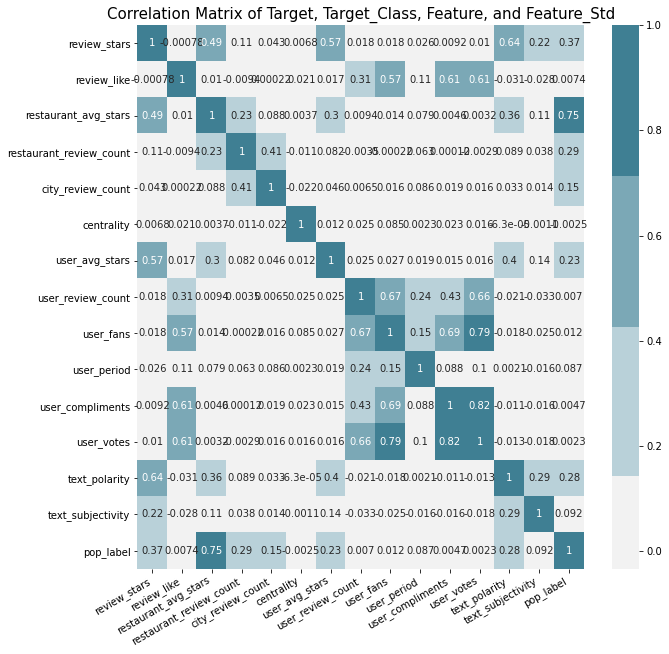

In [82]:
corr_plot(pd.concat([X_train_other, y_train], axis=1))

In [83]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scale_X_train_other = scaler.fit_transform(X_train_other)
scale_X_test_other = scaler.fit_transform(X_test_other)
scale_X_val_other = scaler.fit_transform(X_val_other)

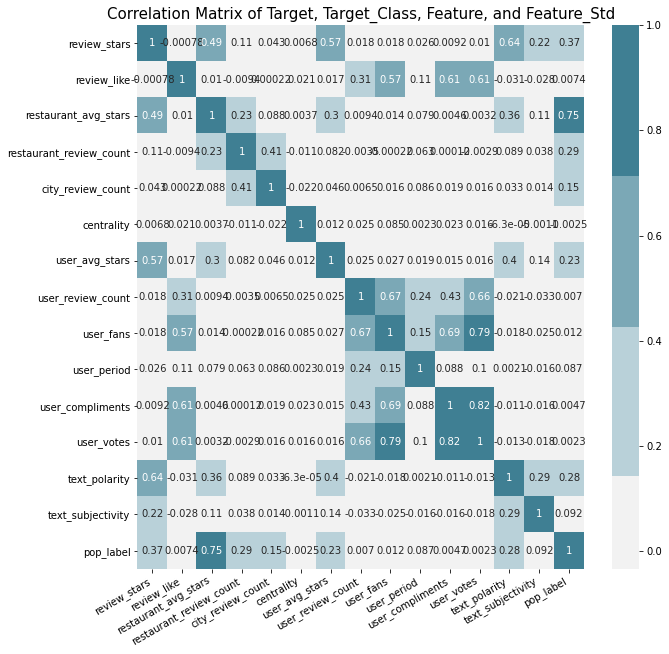

In [84]:
cols_non_text = ['review_stars', 'review_like', 'restaurant_avg_stars', 'restaurant_review_count',
                 'city_review_count', 'centrality', 'user_avg_stars', 'user_review_count', 'user_fans', 
                 'user_period', 'user_compliments','user_votes', 'text_polarity', 'text_subjectivity']
# removed cols: 'text_len'
scale_X_train_other = pd.DataFrame(scale_X_train_other)
scale_X_train_other.columns = cols_non_text

corr_plot(pd.concat([scale_X_train_other, y_train], axis=1))

- combine the vector output along with numerical data

https://datascience.stackexchange.com/questions/987/text-categorization-combining-different-kind-of-features

In [85]:
# X_***All for all text features + numeric features
X_trainAll = np.hstack((trainCounts, X_train_other))
X_testAll = np.hstack((testCounts, X_test_other))
X_valAll = np.hstack((valCounts, X_val_other))

# X_***All_SVD for SVD text features + numeric features
'''
X_trainAll_SVD = pd.concat([pd.DataFrame(svd_trainCounts), X_train_other], axis=1)
X_testAll_SVD = pd.concat([pd.DataFrame(svd_testCounts), X_test_other], axis=1)
X_valAll_SVD = pd.concat([pd.DataFrame(svd_valCounts), X_val_other], axis=1)
'''
X_trainAll_SVD = pd.concat([pd.DataFrame(svd_trainCounts), pd.DataFrame(scale_X_train_other, columns=cols_non_text)], axis=1)
X_testAll_SVD = pd.concat([pd.DataFrame(svd_testCounts), pd.DataFrame(scale_X_test_other, columns=cols_non_text)], axis=1)
X_valAll_SVD = pd.concat([pd.DataFrame(svd_valCounts), pd.DataFrame(scale_X_val_other, columns=cols_non_text)], axis=1)

print("All:", X_trainAll.shape, X_testAll.shape, X_valAll.shape)
print("All_SVD:", X_trainAll_SVD.shape, X_testAll_SVD.shape, X_valAll_SVD.shape)

All: (428724, 1459) (129141, 1459) (102135, 1459)
All_SVD: (428724, 114) (129141, 114) (102135, 114)


In [86]:
'''
# to sparse
from scipy import sparse
newfeatures = sparse.hstack((trainCounts, X_train[['stars']])).tocsr()
print(newfeatures[])
'''

"\n# to sparse\nfrom scipy import sparse\nnewfeatures = sparse.hstack((trainCounts, X_train[['stars']])).tocsr()\nprint(newfeatures[])\n"

## Build Models - Trial of Different Models

<font color=red>These models will be compared based on their performance (F1 score) on test dataset. The best model will be carried on to the next section, that is hyper-parameter fine tuning. So that we can further improve its accuracy.</font>

**possible features: trainCounts, X_train_other, X_trainAll, X_trainAll_SVD**

- xGBoost

In [87]:
'''
from sklearn.pipeline import Pipeline
import xgboost as xgb

#pipe = Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])

model = Pipeline([('xgboost', xgb.XGBClassifier(eta=0.1, max_depth=8, 
                                                objective='multi:softmax', num_class=5))])
# eta=0.1, max_depth=10 -> small RMSE & low accuracy
# eta=0.3, max_depth=10 -> high RMSE & high accuracy
max_delta_step
#model.fit(X_trainAll_SVD, y_train)
'''

'\nfrom sklearn.pipeline import Pipeline\nimport xgboost as xgb\n\n#pipe = Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])\n\nmodel = Pipeline([(\'xgboost\', xgb.XGBClassifier(eta=0.1, max_depth=8, \n                                                objective=\'multi:softmax\', num_class=5))])\n# eta=0.1, max_depth=10 -> small RMSE & low accuracy\n# eta=0.3, max_depth=10 -> high RMSE & high accuracy\nmax_delta_step\n#model.fit(X_trainAll_SVD, y_train)\n'

In [88]:
'''
import xgboost as xgb
y_train.replace({1:0, 2:1, 3:2, 4:3, 5:4},  inplace=True)
dtrain = xgb.DMatrix(X_trainAll_SVD, y_train)
y_test.replace({1:0, 2:1, 3:2, 4:3, 5:4},  inplace=True)
dtest = xgb.DMatrix(X_testAll_SVD, y_test)
'''

'\nimport xgboost as xgb\ny_train.replace({1:0, 2:1, 3:2, 4:3, 5:4},  inplace=True)\ndtrain = xgb.DMatrix(X_trainAll_SVD, y_train)\ny_test.replace({1:0, 2:1, 3:2, 4:3, 5:4},  inplace=True)\ndtest = xgb.DMatrix(X_testAll_SVD, y_test)\n'

In [89]:
'''
# cv
params = {"objective":"multi:softprob",'learning_rate': 0.3,'max_depth': 10}
extra = {'num_class': 5}
params.update(extra)
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=1000,early_stopping_rounds=10,metrics="mlogloss", seed=123)
'''

'\n# cv\nparams = {"objective":"multi:softprob",\'learning_rate\': 0.3,\'max_depth\': 10}\nextra = {\'num_class\': 5}\nparams.update(extra)\ncv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5,\n                    num_boost_round=1000,early_stopping_rounds=10,metrics="mlogloss", seed=123)\n'

In [90]:
#cv_results

In [91]:
#model = xgb.train(params,dtrain,num_boost_round=cv_results.shape[0])

In [92]:
# possible features: trainCounts, X_train_other, X_trainAll, X_trainAll_SVD
from sklearn.pipeline import Pipeline
import xgboost as xgb

model = xgb.XGBClassifier(eta=0.1, max_depth=8, objective='multi:softmax', alpha=1, num_class=5)
eval_set = [(X_valAll_SVD, y_val)]
model.fit(X_trainAll_SVD, y_train, early_stopping_rounds=10, 
          eval_metric="mlogloss", eval_set=eval_set, verbose=True)


[0]	validation_0-mlogloss:1.49209
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.40254
[2]	validation_0-mlogloss:1.33169
[3]	validation_0-mlogloss:1.27514
[4]	validation_0-mlogloss:1.22870
[5]	validation_0-mlogloss:1.18990
[6]	validation_0-mlogloss:1.15783
[7]	validation_0-mlogloss:1.13152
[8]	validation_0-mlogloss:1.10788
[9]	validation_0-mlogloss:1.08834
[10]	validation_0-mlogloss:1.07210
[11]	validation_0-mlogloss:1.05913
[12]	validation_0-mlogloss:1.04811
[13]	validation_0-mlogloss:1.03863
[14]	validation_0-mlogloss:1.03162
[15]	validation_0-mlogloss:1.02593
[16]	validation_0-mlogloss:1.02110
[17]	validation_0-mlogloss:1.01832
[18]	validation_0-mlogloss:1.01575
[19]	validation_0-mlogloss:1.01501
[20]	validation_0-mlogloss:1.01392
[21]	validation_0-mlogloss:1.01483
[22]	validation_0-mlogloss:1.01625
[23]	validation_0-mlogloss:1.01869
[24]	validation_0-mlogloss:1.02122
[25]	validation_0-mlogloss:1.02426
[26]	validation_0-mlogloss:1.02

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

- Naive Bayes

In [93]:
'''
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
model = Pipeline([('Naive Bayes', MultinomialNB())])
model.fit(trainCounts, y_train)
'''

"\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.naive_bayes import MultinomialNB\nmodel = Pipeline([('Naive Bayes', MultinomialNB())])\nmodel.fit(trainCounts, y_train)\n"

- logistic regression

In [94]:

'''
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class = 'multinomial')
model.fit(X_trainAll_SVD, y_train)
'''

"\nfrom sklearn.linear_model import LogisticRegression\nmodel = LogisticRegression(multi_class = 'multinomial')\nmodel.fit(X_trainAll_SVD, y_train)\n"

- stacking

In [95]:
'''
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
#level0.append(('knn', KNeighborsClassifier()))
#level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
#level0.append(('bayes', GaussianNB()))
#### GBM
# define meta learner model
#level1 = LogisticRegression()
level1 = xgb.XGBClassifier(objective='multi:softmax', num_class=5)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X_train_other, y_train)

# make a prediction for one example
#yhat = model.predict_proba(X_test_other)
#print('Predicted Class: %d' % (yhat))
#accuracy_score(resultDF["real_label"], resultDF['grand_mean'])
'''

'\nfrom sklearn.datasets import make_classification\nfrom sklearn.ensemble import StackingClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.naive_bayes import GaussianNB\n\n# define the base models\nlevel0 = list()\nlevel0.append((\'lr\', LogisticRegression()))\n#level0.append((\'knn\', KNeighborsClassifier()))\n#level0.append((\'cart\', DecisionTreeClassifier()))\nlevel0.append((\'svm\', SVC()))\n#level0.append((\'bayes\', GaussianNB()))\n#### GBM\n# define meta learner model\n#level1 = LogisticRegression()\nlevel1 = xgb.XGBClassifier(objective=\'multi:softmax\', num_class=5)\n# define the stacking ensemble\nmodel = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)\n# fit the model on all available data\nmodel.fit(X_train_other, y_train)\n\n# make a prediction for one example\n#yhat = model.predict_proba(X_test_

- prediction

In [96]:
def prediction(X_test):
    # predict
    predict = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)
    #predict = pd.DataFrame(model.predict(X_test))
    predict = predict.add_prefix('pred_')
    
    predict['meanPred'] = 0
    for i in range(1,6):
        predict['meanPred'] = predict['meanPred'] + predict['pred_'+str(i)+'.0'] * i
    #predict['mean'] = predict['sumPred']/(np.sum(predict.iloc[:,0:5], axis=1))
    # sum(pred1~5) = 1

    predict['varPred'] = 0
    for i in range(1,6):
        predict['varPred'] = predict['varPred'] + (predict['pred_'+str(i)+'.0'] * (i - predict['meanPred'])**2)

    predict['repvar'] = 1/predict['varPred']
    predict['w_mean'] = predict['meanPred']/predict['varPred']
    
    #predict.describe()
    
    return(predict)

In [97]:
#X_test_predict = prediction(X_test_other)

## Evaluate models

In [98]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

def evaluate_model(predict_df):
    ## set up
    tempDF = pd.DataFrame({"business_id": X_test_name['business_id'], 
                           "real_label": y_test})
    tempDF = pd.concat([tempDF, predict_df], axis=1)

    resultDF = tempDF.groupby(['business_id', 'real_label']).sum()
    resultDF['grand_mean'] = round(resultDF['w_mean']/resultDF['repvar'], 0)
    resultDF['grand_var'] = 1/resultDF['repvar']
    resultDF.reset_index(inplace=True)
    # resultDF['grand_mean'].describe()
    
    ## accuracy
    accuracy = round(accuracy_score(resultDF["real_label"], resultDF['grand_mean']), 3)
    print("accuracy score:", accuracy)
    print("classification report:\n", classification_report(resultDF["real_label"], resultDF['grand_mean']))
    
    realDummy = pd.get_dummies(resultDF['real_label'], prefix='real')

    ## calculate RMSE
    true_labs = realDummy.to_numpy().argmax(axis=1)+1
    pred_labs = np.round(resultDF['grand_mean'])
    rmse = (mean_squared_error(true_labs, pred_labs))**(0.5)
    print("RMSE:\t", round(rmse, 4))
    
    ## plot confusion matrix
    labels = [1,2,3,4,5]
    #labels = [0,1,2,3,4]
    cm = confusion_matrix(true_labs, pred_labs, labels, normalize='true')
    cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])

    plt.figure(figsize = (10,7))
    ax = plt.subplot()
    sns.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
    return(resultDF, rmse)

accuracy score: 0.391
classification report:
               precision    recall  f1-score   support

         1.0       0.93      0.12      0.22      1050
         2.0       0.30      0.37      0.34      1015
         3.0       0.29      0.60      0.39      1034
         4.0       0.37      0.41      0.39      1130
         5.0       0.88      0.44      0.59      1106

    accuracy                           0.39      5335
   macro avg       0.56      0.39      0.39      5335
weighted avg       0.56      0.39      0.39      5335

RMSE:	 1.0035


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[1, 2, 3, 4, 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


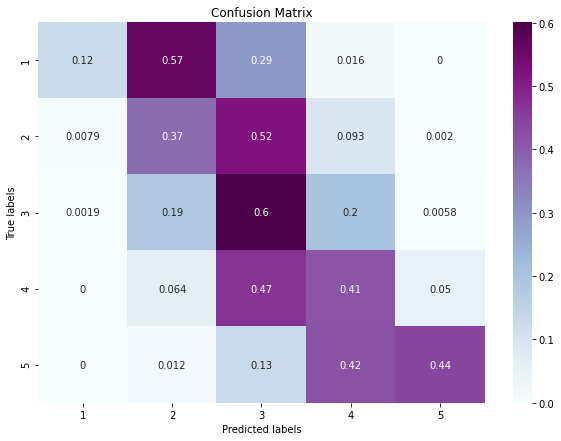

In [99]:
X_test_predict = prediction(X_testAll_SVD)
#X_test_predict = X_test_predict.replace([np.inf, -np.inf], 0)
resultDF, rmse = evaluate_model(X_test_predict)

## Fine Tune Modeling

In [100]:
#X_test_predict.describe()